Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile(joinpath(ProjDir, "m4.1s.jls")) && include(joinpath(ProjDir, "m4.1s.jl"))

chn = deserialize(joinpath(ProjDir, "m4.1s.jls"))

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[7.36982 154.575; 7.68589 155.18; … ; 7.43594 154.768; 7.40371 154.797]

Union{Missing, Float64}[7.86982 154.345; 7.62133 154.696; … ; 7.80554 154.236; 7.8139 154.305]

Union{Missing, Float64}[7.69727 154.486; 7.72836 153.914; … ; 7.65792 153.828; 7.68564 155.01]

Union{Missing, Float64}[8.05423 154.675; 7.81871 153.469; … ; 8.03128 154.344; 8.14415 154.34]

Describe the draws

In [6]:
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
sigma   7.770528 0.28938131 0.0045755203 0.0057334033 1000
   mu 154.604340 0.41451226 0.0065540143 0.0068678508 1000

Quantiles:
         2.5%      25.0%     50.0%     75.0%       97.5%  
sigma   7.227125   7.56995   7.7643   7.9617575   8.353483
   mu 153.770975 154.32900 154.6030 154.8892500 155.399000



Plot the density of posterior draws

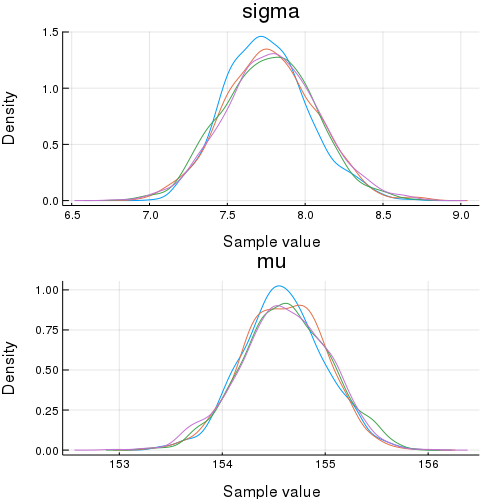

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.15889837747747756
 0.07088508860236677

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
 1.0        0.0985013
 0.0985013  1.0      

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*